## Regression model for predicting SQL execution time

### Step 1. Construct data frame with features and response variable

In [59]:
from multiprocessing import Process, Queue
import glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

plt.style.use('ggplot')

path = r'/data/developer/python'    
allFiles = glob.glob(path + "/SQL_Metrics*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)-([0-9]*)', file_)
    df = pd.read_csv(file_,sep = '@',names = ['stmt_hash','query','exec_time'],index_col=False)
    df['date'] = regex.group(1)
    df['hour'] = regex.group(2)
    df.exec_time = pd.to_numeric(df.exec_time,errors='coerce')
    df.hour = pd.to_numeric(df.hour,errors='coerce')
    list_.append(df)
fdf = pd.concat(list_,ignore_index=True)

fdf = fdf.set_index(['date', 'hour'])
ds = fdf.groupby(fdf.index)['exec_time'].mean()

datehour_list = []
for x in ds.index:
    datehour_list.append((x[0],x[1]))
datehour_df = pd.DataFrame(datehour_list,columns = ['date','hour'])
exec_time_df = pd.DataFrame(ds.values,columns=['avg_exec_time'])
final_df = datehour_df.merge(exec_time_df, left_index = True, right_index=True, how='inner')

final_df = final_df.set_index(['date', 'hour'])

fields = ['time','lock_wait_time','total_section_sort_time','diaglog_write_wait_time','direct_read_time','direct_write_time','log_buffer_wait_time','log_disk_wait_time','pool_read_time','pool_write_time','prefetch_wait_time','total_act_time','total_act_wait_time','total_cpu_time','total_extended_latch_wait_time','span']
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/workload_stats_*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('workload_stats_([0-9]*-[0-9]*-[0-9]*)', file_)
    wldf = pd.read_csv(file_,sep = '@',names = fields,index_col=False)
    list_.append(wldf)
final_wldf = pd.concat(list_,ignore_index=True)
final_wldf['hour'] = 0
final_wldf['date'] = 0
for i in range (0,len(final_wldf)):
    regex = re.search('([0-9-]*)T([0-9]*)', final_wldf.loc[i,('time')])
    final_wldf.loc[i,('date')] = regex.group(1)
    final_wldf.loc[i,('hour')] = int(regex.group(2)) + 1 
    
final_wldf = final_wldf.set_index(['date', 'hour'])
final_wldf.drop('time',axis=1,inplace = True)
final_wldf.drop('span',axis=1,inplace = True)

final_df = final_df.merge(final_wldf, left_index = True, right_index=True, how='inner')

final_df.shape

(22, 15)

In [60]:
print(final_df.avg_exec_time.mean())
print(final_df.avg_exec_time.median())
print(final_df.avg_exec_time.std())

13.717958118560773
5.260574283328721
41.96427914226199


### Step 2. Remove outliers from the features/response variable

In [73]:
import numpy as np
final_df['log_exec_time'] = 0
for i in range (0,len(final_df)):
        final_df.iloc[i,final_df.columns.get_loc('log_exec_time')] = m.log10(final_df.iloc[i].avg_exec_time)
final_df = final_df[np.abs(final_df.log_exec_time-final_df.log_exec_time.mean())<=(2*final_df.log_exec_time.std())]

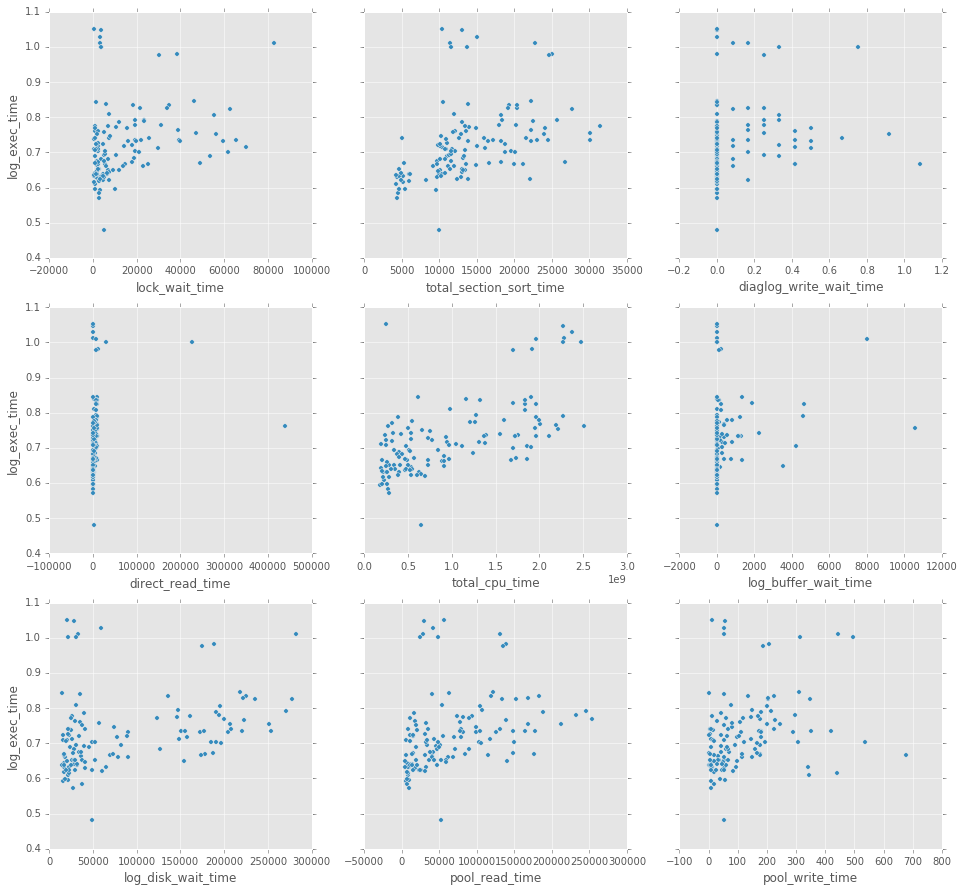

In [74]:
fig, axs = plt.subplots(3, 3, sharey=True)
final_df.plot(kind='scatter', x='lock_wait_time', y='log_exec_time', ax=axs[0][0], figsize=(16, 15))
final_df.plot(kind='scatter', x='total_section_sort_time', y='log_exec_time', ax=axs[0][1])
final_df.plot(kind='scatter', x='diaglog_write_wait_time', y='log_exec_time', ax=axs[0][2])
final_df.plot(kind='scatter', x='direct_read_time', y='log_exec_time', ax=axs[1][0])
final_df.plot(kind='scatter', x='total_cpu_time', y='log_exec_time', ax=axs[1][1])
final_df.plot(kind='scatter', x='log_buffer_wait_time', y='log_exec_time', ax=axs[1][2])
final_df.plot(kind='scatter', x='log_disk_wait_time', y='log_exec_time', ax=axs[2][0])
final_df.plot(kind='scatter', x='pool_read_time', y='log_exec_time', ax=axs[2][1])
final_df.plot(kind='scatter', x='pool_write_time', y='log_exec_time', ax=axs[2][2])

In [115]:
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='log_exec_time ~ lock_wait_time', data=final_df).fit()
lm2 = smf.ols(formula='log_exec_time ~ total_section_sort_time', data=final_df).fit()
lm3 = smf.ols(formula='log_exec_time ~ diaglog_write_wait_time', data=final_df).fit()
lm4 = smf.ols(formula='log_exec_time ~ direct_read_time', data=final_df).fit()
lm5 = smf.ols(formula='log_exec_time ~ total_cpu_time', data=final_df).fit()
lm6 = smf.ols(formula='log_exec_time ~ log_buffer_wait_time', data=final_df).fit()
lm7 = smf.ols(formula='log_exec_time ~ log_disk_wait_time', data=final_df).fit()
lm8 = smf.ols(formula='log_exec_time ~ pool_read_time', data=final_df).fit()
lm9 = smf.ols(formula='log_exec_time ~ pool_write_time', data=final_df).fit()
print ('Summary for lock_wait_time')
print(lm1.summary(),"\n\n\n")
print ('Summary for total_section_sort_time')
print(lm2.summary(),"\n\n\n")
print ('Summary for total_cpu_time')
print(lm5.summary())


Summary for lock_wait_time
                            OLS Regression Results                            
Dep. Variable:          log_exec_time   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.49
Date:                Wed, 13 Jul 2016   Prob (F-statistic):            0.00154
Time:                        16:53:26   Log-Likelihood:                 110.68
No. Observations:                 125   AIC:                            -217.4
Df Residuals:                     123   BIC:                            -211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        

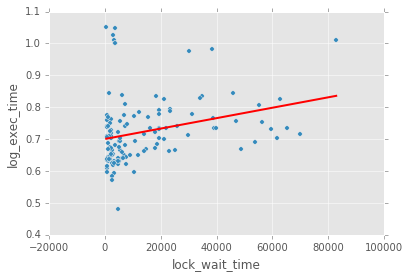

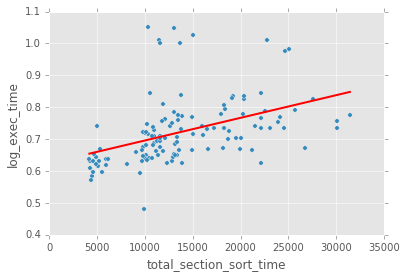

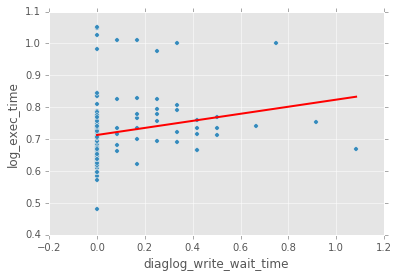

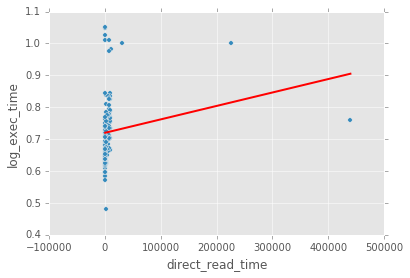

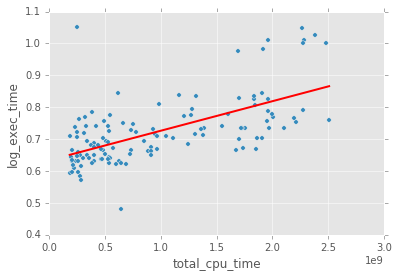

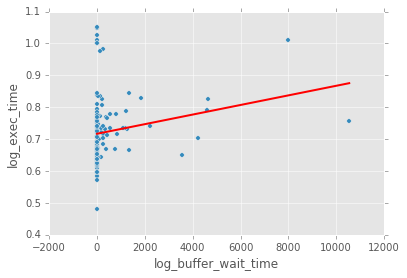

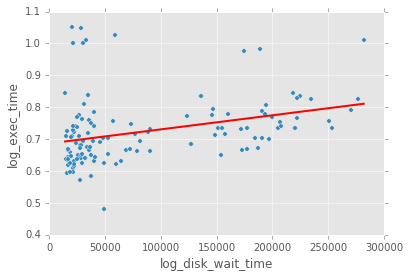

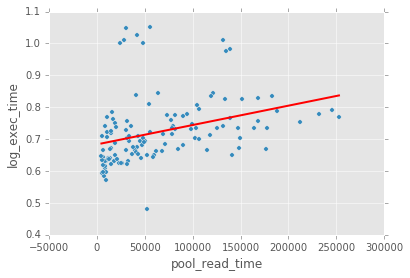

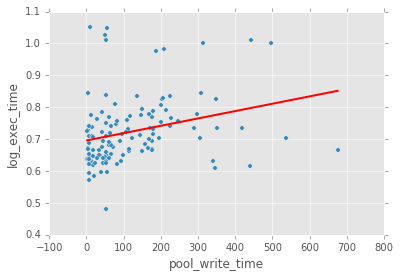

In [76]:
X_new1 = pd.DataFrame({'lock_wait_time': [final_df.lock_wait_time.min(), final_df.lock_wait_time.max()]})
preds1 = lm1.predict(X_new1)

X_new2 = pd.DataFrame({'total_section_sort_time': [final_df.total_section_sort_time.min(), final_df.total_section_sort_time.max()]})
preds2 = lm2.predict(X_new2)

X_new3 = pd.DataFrame({'diaglog_write_wait_time': [final_df.diaglog_write_wait_time.min(), final_df.diaglog_write_wait_time.max()]})
preds3 = lm3.predict(X_new3)

X_new4 = pd.DataFrame({'direct_read_time': [final_df.direct_read_time.min(), final_df.direct_read_time.max()]})
preds4 = lm4.predict(X_new4)

X_new5 = pd.DataFrame({'total_cpu_time': [final_df.total_cpu_time.min(), final_df.total_cpu_time.max()]})
preds5 = lm5.predict(X_new5)

X_new6 = pd.DataFrame({'log_buffer_wait_time': [final_df.log_buffer_wait_time.min(), final_df.log_buffer_wait_time.max()]})
preds6 = lm6.predict(X_new6)

X_new7 = pd.DataFrame({'log_disk_wait_time': [final_df.log_disk_wait_time.min(), final_df.log_disk_wait_time.max()]})
preds7 = lm7.predict(X_new7)

X_new8 = pd.DataFrame({'pool_read_time': [final_df.pool_read_time.min(), final_df.pool_read_time.max()]})
preds8 = lm8.predict(X_new8)

X_new9 = pd.DataFrame({'pool_write_time': [final_df.pool_write_time.min(), final_df.pool_write_time.max()]})
preds9 = lm9.predict(X_new9)


#fig, axs = plt.subplots(1, 3, sharey=True)

final_df.plot(kind='scatter', x='lock_wait_time', y='log_exec_time')
plt.plot(X_new1, preds1, c='red', linewidth=2)

final_df.plot(kind='scatter', x='total_section_sort_time', y='log_exec_time')
plt.plot(X_new2, preds2, c='red', linewidth=2)

final_df.plot(kind='scatter', x='diaglog_write_wait_time', y='log_exec_time')
plt.plot(X_new3, preds3, c='red', linewidth=2)

final_df.plot(kind='scatter', x='direct_read_time', y='log_exec_time')
plt.plot(X_new4, preds4, c='red', linewidth=2)

final_df.plot(kind='scatter', x='total_cpu_time', y='log_exec_time')
plt.plot(X_new5, preds5, c='red', linewidth=2)

final_df.plot(kind='scatter', x='log_buffer_wait_time', y='log_exec_time')
plt.plot(X_new6, preds6, c='red', linewidth=2)

final_df.plot(kind='scatter', x='log_disk_wait_time', y='log_exec_time')
plt.plot(X_new7, preds7, c='red', linewidth=2)

final_df.plot(kind='scatter', x='pool_read_time', y='log_exec_time')
plt.plot(X_new8, preds8, c='red', linewidth=2)

final_df.plot(kind='scatter', x='pool_write_time', y='log_exec_time')
plt.plot(X_new9, preds9, c='red', linewidth=2)

In [99]:
X_new2 = pd.DataFrame({'lock_wait_time': [final_df.lock_wait_time]})

In [105]:
x_new2 = final_df['lock_wait_time']

In [106]:
x_new2

date        hour
2016-06-06  1         863.833333
            3         590.583333
            6         936.250000
            8        5073.916667
            9       69796.000000
            10      29919.250000
            11      15517.000000
            12      56245.833333
            13      14847.833333
2016-06-07  2        3374.000000
            3        1651.333333
            5        6922.000000
            6        2171.166667
            7        2151.916667
            8        7326.666667
            9       59516.583333
            10      23252.750000
            12      46916.583333
            13      39090.583333
            14      23296.166667
            15      19195.083333
            16      38868.000000
            17      19336.500000
            18      18763.750000
            19      13921.250000
            20       5383.333333
            21       2025.500000
            22       3331.833333
2016-06-08  2        3684.750000
            3        7291.